In [21]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm
import time

from utils import set_plotting_style, get_chunking, get_chunking_dask, make_df_dask, hist2d_dask, query_dis
import utils

from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask import delayed
from yahist import Hist1D, Hist2D

In [22]:
set_plotting_style()

Make dask client

In [23]:
client = Client("tcp://169.228.130.74:3223")
client

Client Scheduler: tcp://169.228.130.74:3223 Dashboard: http://169.228.130.74:13345/status,Cluster Workers: 20 Cores: 20 Memory: 80.00 GB


Figure out which sites have which datasets. Pick something local to speed things up.

In [24]:
query = "/DYJetsToLL_M-50_HT-*_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/NANOAODSIM"
query_dis(query, typ="sites")

[{'dataset': '/DYJetsToLL_M-50_HT-1200to2500_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/NANOAODSIM',
  'site_fractions': [['T2_EE_Estonia', 1.0],
   ['T1_IT_CNAF_MSS', 1.0],
   ['T2_US_Purdue', 1.0],
   ['T1_IT_CNAF_Buffer', 1.0],
   ['T1_US_FNAL_Disk', 1.0],
   ['T2_US_Wisconsin', 0.882]]},
 {'dataset': '/DYJetsToLL_M-50_HT-70to100_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/NANOAODSIM',
  'site_fractions': [['T1_US_FNAL_MSS', 1.0],
   ['T2_EE_Estonia', 1.0],
   ['T1_US_FNAL_Buffer', 1.0],
   ['T2_IT_Legnaro', 1.0],
   ['T2_US_Purdue', 1.0],
   ['T2_US_Nebraska', 1.0],
   ['T2_DE_DESY', 0.345],
   ['T2_US_Florida', 0.092],
   ['T2_US_MIT', 0.001]]},
 {'dataset': '/DYJetsToLL_M-50_HT-600to800_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/NANOAODSIM',
  'site_fractions': [['T2_E

Picked a dataset. Now get the list of files.

In [25]:
%%time

dataset = "/DYJetsToLL_M-50_HT-100to200_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8/RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/NANOAODSIM"
df = pd.DataFrame(query_dis(dataset, typ="files"))
fnames = tuple(df.name)
print(f"{len(df)} files, {df.nevents.sum()} events")

10 files, 9636121 events
CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 27 ms


Make a function that takes information about a "chunk": filename and start/stop entry number. The function returns a flat pandas DataFrame. In this case, we read muon 4-momenta and MET, and store MET, dimuon masses for events with exactly two muons. We run the function on a small chunk to test it.

In [26]:
def func(fname, entrystart, entrystop):
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(["Muon_pt","Muon_eta","Muon_phi","Muon_mass","MET_pt"],
                    outputtype=dict,namedecode="ascii",
                    entrystart=entrystart,entrystop=entrystop)
    sel = (arrs["Muon_pt"].counts == 2)
    df = pd.DataFrame()
    TLVA = uproot_methods.TLorentzVectorArray
    mus = TLVA.from_ptetaphim(arrs["Muon_pt"][sel],arrs["Muon_eta"][sel],arrs["Muon_phi"][sel],arrs["Muon_mass"][sel])
    mass = (mus[:,0]+mus[:,1]).mass
    df["dimuon_mass"] = mass
    df["MET_pt"] = arrs["MET_pt"][sel]
    return df

func(fnames[0].replace("/store/","root://cmsxrootd.fnal.gov//store/"), 0, 10000)

,dimuon_mass,MET_pt
0,89.262779,11.192041
1,91.561005,14.792266
2,91.243340,13.890943
3,93.040024,67.413521
4,12.945415,62.856010
...,...,...
2144,93.058914,6.718247
2145,92.248474,30.783525
2146,192.114288,19.874645
2147,89.099884,6.147094


Run over the full set of files and make a dask DataFrame, passing in our custom `func`, and persisting it so it stays in memory.

In [27]:
ddf = make_df_dask(
    fnames,
    func = func,
    persist = True,
    xrootd = True
)

Make a helper function to plot a histogram from an expression and bins.

In [28]:
def get_hist(df, varexp, bins):
    t0 = time.time()
    counts = da.histogram(da.clip(df.eval(varexp),bins[0],bins[-1]), bins=bins)[0].compute()
    t1 = time.time()
    print(f"{counts.sum()} events in {t1-t0:.2f}s @ {counts.sum()/(t1-t0)*1e-6:.2f}MHz")
    h = Hist1D.from_bincounts(counts, bins, errors=counts**0.5)
    return h

The first time we make a histogram will be slow because at this point, the dask DataFrame is still being created/persisted. As the chunks are computed, the histogram is calculated until they are all done and summed together. Thus, this cell will block.

2080729 events in 107.67s @ 0.02MHz


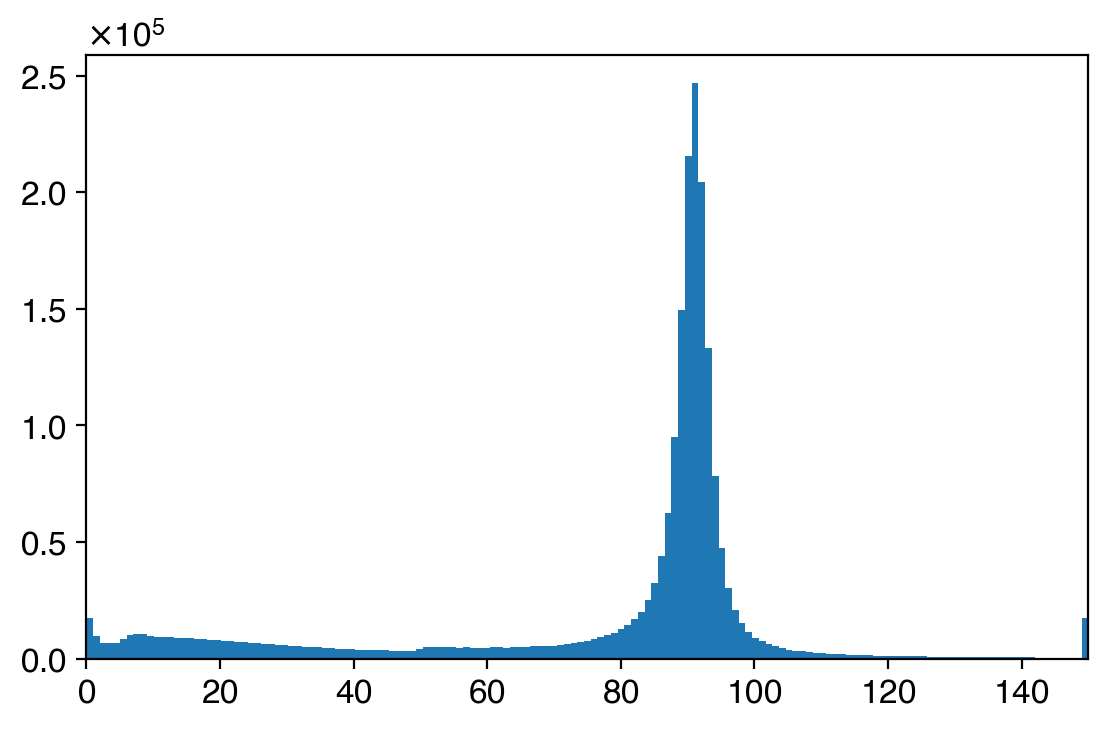

In [29]:
h = get_hist(ddf, "dimuon_mass", bins=np.linspace(0,150,150))
h.plot()

The second run will be super fast because now the dask DataFrame is fully in memory.

2080731 events in 0.16s @ 12.71MHz


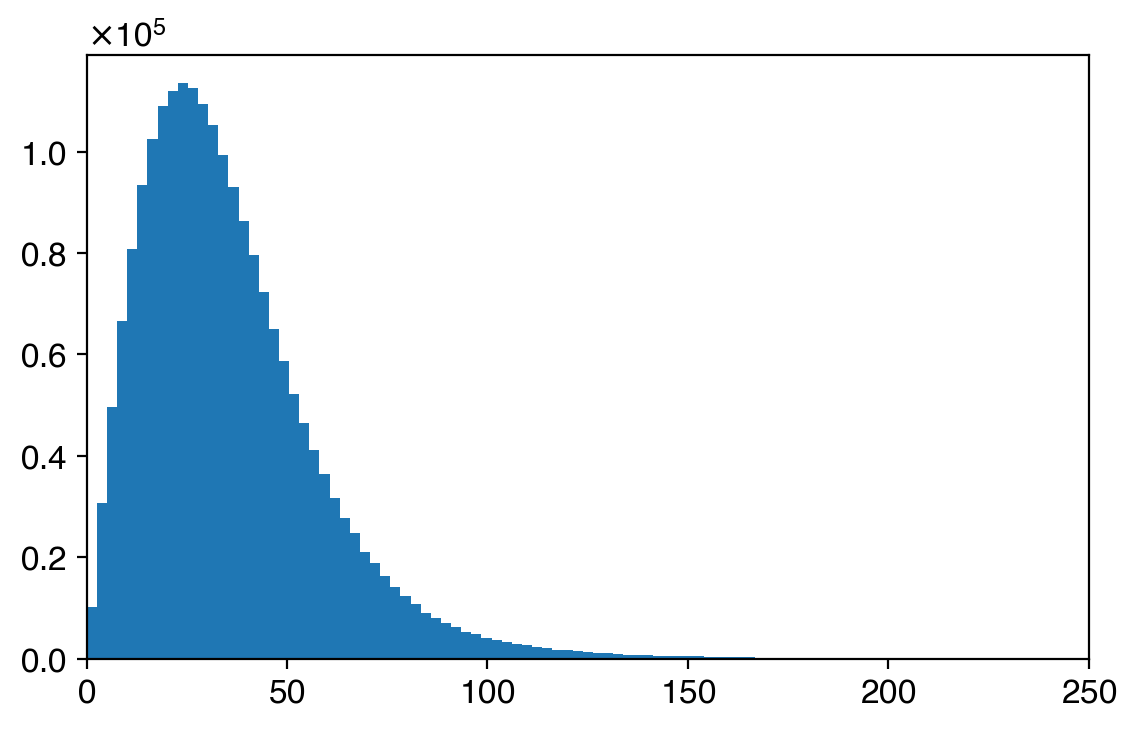

In [32]:
h = get_hist(ddf, "MET_pt", bins=np.linspace(0,250,100))
h.plot()

How much memory is the dask DataFrame occupying?

In [34]:
print(f"Memory usage: {1e-6*ddf.memory_usage().compute().sum():.2f}MB")

Memory usage: 16.65MB
